<a href="https://colab.research.google.com/github/abwahab175/Diabetic_Retinopathy/blob/main/Diabetic_Retinopathyc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#dataSet https://www.kaggle.com/datasets/sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-gaussian-filtered

 98% 417M/427M [00:05<00:00, 106MB/s] 
100% 427M/427M [00:05<00:00, 74.6MB/s]


In [14]:
import zipfile
zip_ref = zipfile.ZipFile('/content/diabetic-retinopathy-224x224-gaussian-filtered.zip', 'r')
zip_ref.extractall('/content/diabetic-retinopathy')
zip_ref.close()

In [7]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [9]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'/content/diabetic-retinopathy/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: >

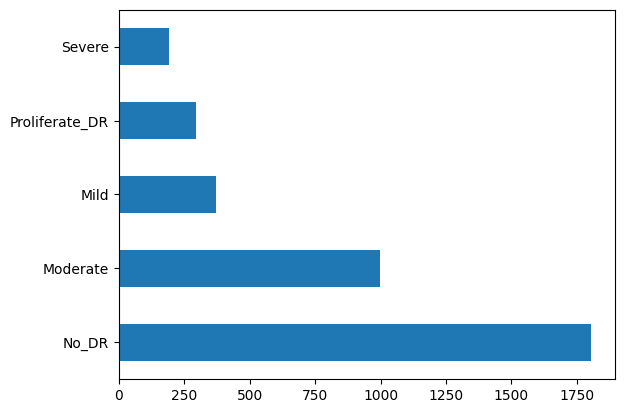

In [10]:
df['type'].value_counts().plot(kind='barh')

<Axes: >

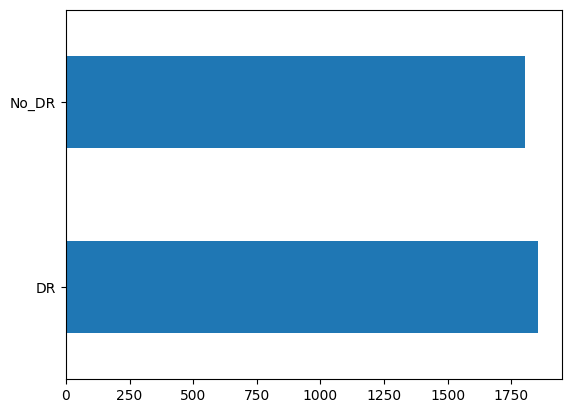

In [11]:
df['binary_type'].value_counts().plot(kind='barh')

In [12]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')

No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 

No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: type, dtype: int64 



In [15]:
# Create working directories for train/val/test
base_dir = '/content/diabetic-retinopathy/Data'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [16]:
# Copy images to respective working directory
src_dir = r'/content/diabetic-retinopathy/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [17]:
# Setting up ImageDataGenerator for train/val/test

train_path = '/content/diabetic-retinopathy/Data/train'
val_path = '/content/diabetic-retinopathy/Data/val'
test_path = '/content/diabetic-retinopathy/Data/test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [18]:
# Building the model

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 8)       0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 111, 111, 8)       32        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 16)        0         
 g2D)                                                            
                                                        

In [20]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [21]:
history = model.fit(train_batches,epochs=30,validation_data=val_batches)

Epoch 1/30
81/81 [==============================] - 21s 110ms/step - loss: 0.3204 - accuracy: 0.8950 - val_loss: 0.6902 - val_accuracy: 0.5073
Epoch 2/30
81/81 [==============================] - 8s 98ms/step - loss: 0.1845 - accuracy: 0.9325 - val_loss: 0.5318 - val_accuracy: 0.6545
Epoch 3/30
81/81 [==============================] - 10s 119ms/step - loss: 0.1288 - accuracy: 0.9516 - val_loss: 1.2329 - val_accuracy: 0.4964
Epoch 4/30
81/81 [==============================] - 9s 108ms/step - loss: 0.0844 - accuracy: 0.9672 - val_loss: 0.4605 - val_accuracy: 0.7418
Epoch 5/30
81/81 [==============================] - 9s 109ms/step - loss: 0.0602 - accuracy: 0.9770 - val_loss: 0.5996 - val_accuracy: 0.7273
Epoch 6/30
81/81 [==============================] - 8s 97ms/step - loss: 0.0505 - accuracy: 0.9824 - val_loss: 0.4068 - val_accuracy: 0.8800
Epoch 7/30
81/81 [==============================] - 9s 108ms/step - loss: 0.0375 - accuracy: 0.9856 - val_loss: 0.2327 - val_accuracy: 0.9255
Epoch 

In [22]:
model.save('Diabetic_Retinopathyc-CNN.model')

In [23]:
loss, acc = model.evaluate_generator(test_batches, verbose=1)
# print("Loss: ", loss)
print("Accuracy: ", acc)

<ipython-input-23-f081ff5ff9c3>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_batches, verbose=1)


18/18 [==============================] - 2s 81ms/step - loss: 0.6656 - accuracy: 0.9345
Accuracy:  0.9345454573631287


In [24]:
# Diabet Retinopathy Detection Section

In [39]:
from keras.src.layers.preprocessing.image_preprocessing import Rescaling
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0
    Img_Gen=ImageDataGenerator(rescale = 1./255).
    print(image)
    new_model = tf.keras.models.load_model("Diabetic_Retinopathyc-CNN.model")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')



[0.5019608 0.5019608 0.5019608]


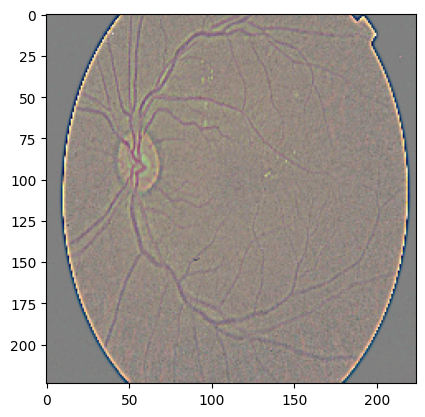

In [45]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import numpy as np
from matplotlib import pyplot

img = load_img('/content/diabetic-retinopathy/Data/test/DR/01b3aed3ed4c.png')
img_arr = np.expand_dims(img_to_array(img), axis=0)
datagen = ImageDataGenerator(rescale=1./255)

for batch in datagen.flow(img_arr, batch_size=1, save_to_dir='/content/', save_prefix='1_param', save_format='jpeg'):
    print(batch[0][0][0])
    pyplot.imshow(batch[0])
    pyplot.show()
    break

[[[0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  ...
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]]

 [[0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  ...
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]]

 [[0.50196078 0.50196078 0.50196078]
  [0.49019608 0.51372549 0.50196078]
  [0.50196078 0.51764706 0.50196078]
  ...
  [0.50196078 0.51764706 0.50196078]
  [0.49019608 0.51372549 0.50196078]
  [0.50196078 0.50196078 0.50196078]]

 ...

 [[0.51764706 0.50196078 0.50196078]
  [0.50588235 0.49803922 0.50196078]
  [0.50980392 0.50980392 0.50980392]
  ...
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]]

 [[0.51764706 0.50196078 0.50196078]
  [0.50588235 0.49803922 0.50196078]


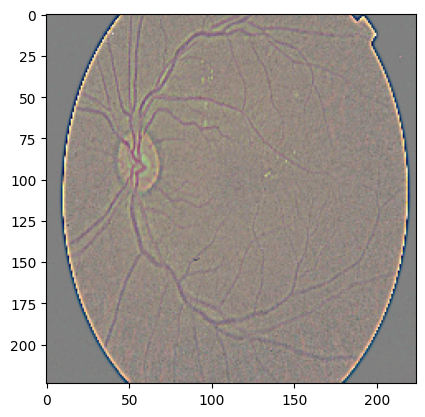

In [40]:
predict_class('/content/diabetic-retinopathy/Data/test/DR/01b3aed3ed4c.png')

[[[0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  ...
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]]

 [[0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  ...
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]]

 [[0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  ...
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]]

 ...

 [[0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  ...
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]]

 [[0.50196078 0.50196078 0.50196078]
  [0.50196078 0.50196078 0.50196078]


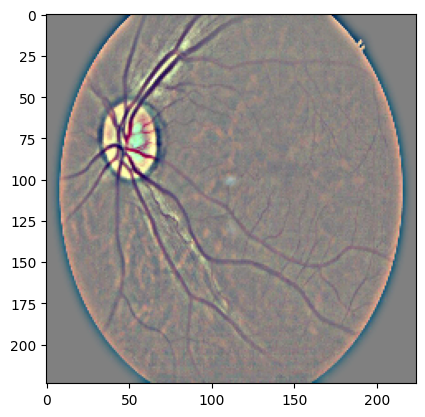

In [41]:
predict_class('/content/diabetic-retinopathy/Data/val/No_DR/0da321efbce6.png')

[[[0.02352941 0.02352941 0.01176471]
  [0.01960784 0.01960784 0.01176471]
  [0.01960784 0.02352941 0.00392157]
  ...
  [0.01960784 0.01960784 0.01176471]
  [0.01568627 0.01960784 0.01176471]
  [0.01960784 0.01568627 0.00784314]]

 [[0.02352941 0.02352941 0.01568627]
  [0.01960784 0.01960784 0.01568627]
  [0.01960784 0.01960784 0.01176471]
  ...
  [0.01960784 0.01568627 0.00784314]
  [0.01960784 0.02352941 0.00392157]
  [0.02745098 0.02352941 0.00784314]]

 [[0.02352941 0.01960784 0.01176471]
  [0.01960784 0.01960784 0.01176471]
  [0.01960784 0.01960784 0.01176471]
  ...
  [0.02745098 0.02352941 0.01568627]
  [0.01960784 0.01960784 0.01176471]
  [0.01568627 0.02352941 0.00392157]]

 ...

 [[0.03529412 0.03921569 0.04705882]
  [0.03137255 0.03529412 0.04313725]
  [0.03137255 0.03529412 0.04313725]
  ...
  [0.03137255 0.03529412 0.03921569]
  [0.03137255 0.03529412 0.04313725]
  [0.01960784 0.03529412 0.03137255]]

 [[0.03137255 0.03529412 0.04313725]
  [0.03137255 0.03529412 0.04313725]


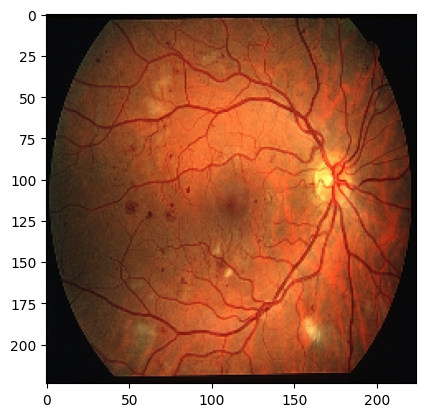

In [42]:
predict_class("/content/out.jpg")

1/1 [==============================] - 0s 98ms/step
No DR


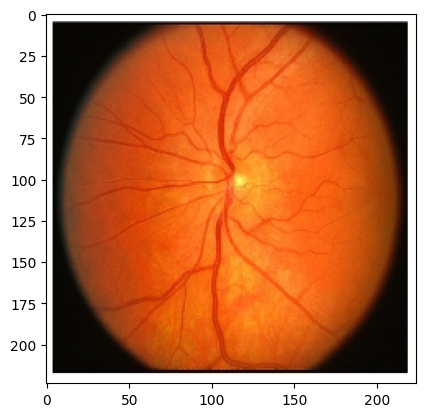

In [36]:
predict_class('/content/noDR.png')

1/1 [==============================] - 0s 99ms/step
No DR


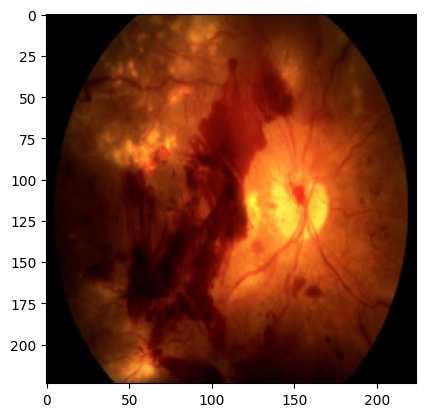

In [37]:
predict_class('/content/diabetic-retinopathy_420.jpg')